# Benchmark & costs report for metadata generation

In [1]:
import requests
import pandas as pd
import time
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

import woo_hoo

from pathlib import Path
from rapidfuzz import fuzz
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle,
    ListFlowable, ListItem, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4


from woo_hoo.services.document_extractor import extract_text_from_bytes
from woo_hoo.services.metadata_generator import MetadataGenerator
from woo_hoo.models.requests import MetadataGenerationRequest, DocumentContent


## Data exploration

In [2]:
url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
params = {
    "zoektekst": "klimaat",
    "start": 0,
    "aantalResultaten": 20
}

response = requests.get(url, params=params)
data = response.json()

In [3]:
print(data.keys())

dict_keys(['totaal', 'resultaten', 'filters'])


In [4]:
# example metadata of document
data["resultaten"][0]

{'document': {'id': 'oep-3497afb8171f944f3fd579e07104cd6613e46312_1',
  'pid': 'https://open.overheid.nl/documenten/oep-3497afb8171f944f3fd579e07104cd6613e46312',
  'titel': 'Wet van 28 januari 2026, houdende wijziging van de begrotingsstaten van het Ministerie van Klimaat en Groene Groei (XXIII) voor het jaar 2025 (wijziging samenhangende met de Najaarsnota)',
  'openbaarmakingsdatum': '2026-02-24',
  'weblocatie': 'https://zoek.officielebekendmakingen.nl/stb-2026-35-n1.html',
  'publisher': 'ministerie van Justitie en Veiligheid',
  'aanbieder': 'officielebekendmakingen.nl',
  'mutatiedatumtijd': '2026-02-24T08:33:28.865Z'},
 'bestandsgrootte': '0.03 MB',
 'bestandsType': 'application/pdf',
 'highlightedText': 'Staatsblad van het Koninkrijk der Nederlanden Wet van 28\xa0januari 2026 houdende wijziging van de begrotingsstaten van het Ministerie van <b>Klimaat</b> en Groene Groei XXIII voor het jaar 2025 wijziging samenhangende met de Najaarsnota'}

## Create testset

In [5]:
def fetch_official_metadata(doc_id: str) -> dict:
    url = f"https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek/{doc_id}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

In [6]:
def fetch_doc_ids_with_pdf(n=20):
    base_url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
    
    doc_ids = []
    start = 0
    
    while len(doc_ids) < n:
        
        params = {
            "zoektekst": "",
            "start": start,
            "aantalResultaten": 20
        }

        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        results = data.get("resultaten", [])
        if not results:
            break

        for r in results:
            doc_id = r["document"]["id"]
            
            detail = fetch_official_metadata(doc_id)
            time.sleep(0.2)

            if not detail:
                continue

            pdf_url = None
            versies = detail.get("versies") or []

            if len(versies) > 0:
                bestanden = versies[0].get("bestanden") or []
                if len(bestanden) > 0:
                    pdf_url = bestanden[0].get("id")

            if pdf_url:
                doc_ids.append(doc_id)

            if len(doc_ids) >= n:
                break

        start += 20

    return doc_ids

### Select amount of docs for testset

In [7]:
# get x amount of doc_ids
doc_ids = fetch_doc_ids_with_pdf(20)
doc_ids

['oep-3497afb8171f944f3fd579e07104cd6613e46312_1',
 'oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1',
 'oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1',
 'oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1',
 'oep-e1cf95192620b833edf9034f823fdca891921427_1',
 'oep-e6edf96dc002c95050ef793a546840b2e3e97435_1',
 'oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1',
 'oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1',
 'oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1',
 'oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1',
 'oep-ob-93dd11296bb6b51c787347c913d3c3baab64b42e_1',
 'oep-ob-f60c5d3673640c1dc0e1089ac561d1b13dd48749_1',
 'oep-058b752a66d54510a6375201b58ae690e09b86c0_1',
 'oep-5570a798dc28597e991deb70f9b4745154720845_1',
 'oep-9f6a538cb3b5014c0e3f6e10549a617557818184_1',
 'oep-a68e23b0ad91864370be2f2c8989069d63c400a6_1',
 'oep-e8acc197366901e4058f826176325fba35ed07ff_1',
 'oep-efb51233f4023a35333f5d57e666c0040043e0b2_1',
 'oep-fc0dd3fc4a1228ab55c00d63f58ab5361db8925d_1',
 'oep-06ddc6d

## Generate metadata & calculate benchmark scores / costs

In [8]:
# PDF url to test with
pdf_url = "https://open.overheid.nl/documenten/oep-ob-35b90fb89d64b1009ae2a22c8afde5733aab839a/pdf"

In [9]:
generator = MetadataGenerator()

async def generate_metadata_from_pdf_url(pdf_url: str):

    # 1. download PDF
    response = requests.get(pdf_url)
    response.raise_for_status()
    pdf_bytes = response.content

    # 2. extract text
    try:
        text = extract_text_from_bytes(pdf_bytes, filename="document.pdf")
    except Exception:
        return None

    # 3. build request
    request = MetadataGenerationRequest(
        document=DocumentContent(
            text=text,
            filename="document.pdf",
            source_url=pdf_url
        ),
        include_confidence=True
    )

    # 4. generate metadata
    result = await generator.generate(request)

    return result


In [10]:
FIELDS_TO_COMPARE = {
    "direct_fields": [
        "titel",
        "omschrijving",
        "identifiers",
        "informatiecategorieen",
        "documentsoorten",
        "trefwoorden",
        "naam_opsteller"
    ],
    "organisation_fields": [
        "publisher",
        "verantwoordelijke",
        "opsteller"
    ]
}

STRATEGIES = [
    "semantic_similarity",   # fuzzy string
    "semantic_overlap",      # lijst fuzzy
    "set_overlap",           # identifiers
    "exact_match",           # datum
    "fuzzy_string"           # organisaties / naam
]

COMPARISON_STRATEGY = {
    "titel": "semantic_similarity",
    "omschrijving": "semantic_similarity",
    "identifiers": "set_overlap",
    "informatiecategorieen": "semantic_overlap",
    "documentsoorten": "semantic_overlap",
    "trefwoorden": "semantic_overlap",
    "naam_opsteller": "fuzzy_string",
    "publisher": "fuzzy_string",
    "verantwoordelijke": "fuzzy_string",
    "opsteller": "fuzzy_string",
}


### Functions for normalization and comparisons

In [11]:
def normalize_text(text: str | None) -> str:
    if not text:
        return ""
    
    text = text.lower()
    text = re.sub(r"[_\-]", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [12]:
def compare_semantic_similarity(a: str | None, b: str | None) -> float:
    a_norm = normalize_text(a)
    b_norm = normalize_text(b)
    
    if not a_norm or not b_norm:
        return 0.0
    
    return fuzz.token_set_ratio(a_norm, b_norm) / 100

In [13]:
def compare_semantic_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    scores = []

    for item_a in list_a:
        a_norm = normalize_text(item_a)
        best_score = 0

        for item_b in list_b:
            b_norm = normalize_text(item_b)
            score = fuzz.token_set_ratio(a_norm, b_norm)
            best_score = max(best_score, score)

        scores.append(best_score / 100)

    return sum(scores) / len(scores)

In [14]:
def compare_set_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    set_a = set(normalize_text(x) for x in list_a)
    set_b = set(normalize_text(x) for x in list_b)

    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    if not union:
        return 0.0

    return len(intersection) / len(union)

In [15]:
def compare_exact_match(a, b) -> float:
    return 1.0 if a == b else 0.0

In [16]:
def compare_fuzzy_string(a: str | None, b: str | None) -> float:
    return compare_semantic_similarity(a, b)

In [17]:
def compare_field(field_name, official_value, llm_value):
    strategy_map = {
        "titel": compare_semantic_similarity,
        "omschrijving": compare_semantic_similarity,
        "informatiecategorieen": compare_semantic_overlap,
        "documentsoorten": compare_semantic_overlap,
        "trefwoorden": compare_semantic_overlap,
        "identifiers": compare_set_overlap,
        "naam_opsteller": compare_fuzzy_string,
        "publisher": compare_fuzzy_string,
        "verantwoordelijke": compare_fuzzy_string,
        "opsteller": compare_fuzzy_string,
    }

    func = strategy_map[field_name]
    return func(official_value, llm_value)


### Functions for metadata fields extraction

In [18]:
# get official metadata
def extract_official_fields(official_json: dict) -> dict:
    doc = official_json.get("document", official_json)

    omschrijving = (
        doc.get("omschrijving")
        or (
            doc.get("omschrijvingen")[0]
            if doc.get("omschrijvingen")
            else None
        )
    )

    data = {
        "titel": doc.get("titel") 
                 or doc.get("titelcollectie", {}).get("officieleTitel"),

        "omschrijving": omschrijving,

        "identifiers": doc.get("identifiers"),

        "informatiecategorieen": [
            cat.get("label")
            for cat in doc.get("classificatiecollectie", {})
                          .get("informatiecategorieen", [])
        ],

        "documentsoorten": [
            soort.get("label")
            for soort in doc.get("classificatiecollectie", {})
                            .get("documentsoorten", [])
        ],

        "trefwoorden": (
            doc.get("classificatiecollectie", {})
               .get("trefwoorden")
            or []
        ),

        "naam_opsteller": doc.get("naamOpsteller"),

        "publisher": (
            doc.get("publisher", {}).get("label")
            if isinstance(doc.get("publisher"), dict)
            else doc.get("publisher")
        ),

        "verantwoordelijke": (
            doc.get("verantwoordelijke", {}).get("label")
            if isinstance(doc.get("verantwoordelijke"), dict)
            else None
        ),

        "opsteller": (
            doc.get("opsteller", {}).get("label")
            if isinstance(doc.get("opsteller"), dict)
            else None
        ),
    }

    return data


In [19]:
# get generated metadata
def extract_llm_fields(diwoo_metadata) -> dict:
    
    data = {
        "titel": diwoo_metadata.titelcollectie.officiele_titel,

        "omschrijving": (
            diwoo_metadata.omschrijvingen[0]
            if diwoo_metadata.omschrijvingen
            else None
        ),

        "identifiers": diwoo_metadata.identifiers,

        "informatiecategorieen": [
            cat.categorie.name
            for cat in diwoo_metadata.classificatiecollectie.informatiecategorieen
        ],

        "documentsoorten": [
            soort.soort.name
            for soort in diwoo_metadata.classificatiecollectie.documentsoorten or []
        ],

        "trefwoorden": diwoo_metadata.classificatiecollectie.trefwoorden,

        "naam_opsteller": diwoo_metadata.naam_opsteller,

        "publisher": diwoo_metadata.publisher.label if diwoo_metadata.publisher else None,

        "verantwoordelijke": (
            diwoo_metadata.verantwoordelijke.label
            if diwoo_metadata.verantwoordelijke else None
        ),

        "opsteller": (
            diwoo_metadata.opsteller.label
            if diwoo_metadata.opsteller else None
        ),
    }

    return data


### Caclulate benchmark scores & costs

In [20]:
# get PDF url
def get_pdf_url_from_official_metadata(official_metadata_json):
    return official_metadata_json.get("versies", [{}])[0] \
                                .get("bestanden", [{}])[0] \
                                .get("id")

In [21]:
# get official metadata
def prepare_document(doc_id: str):
    official_metadata_json = fetch_official_metadata(doc_id)
    pdf_url = get_pdf_url_from_official_metadata(official_metadata_json)

    if not pdf_url:
        return None, None

    return official_metadata_json, pdf_url

In [22]:
# calculate benchmark scores for single document
async def benchmark_from_result(doc_id: str, official_metadata_json: dict, result):

    # 1. official metadata
    official_fields = extract_official_fields(official_metadata_json)

    if result is None or (hasattr(result, "success") and not result.success):
        return None

    # 2. LLM fields
    llm_fields = extract_llm_fields(result.suggestion.metadata)

    # 3. calculate scores
    rows = []

    for field, official_value in official_fields.items():
        if field == "creatiedatum":
            continue

        if official_value is None:
            continue

        if isinstance(official_value, list) and len(official_value) == 0:
            continue

        llm_value = llm_fields.get(field)
        score = compare_field(field, official_value, llm_value)

        if score is None:
            continue

        rows.append({
            "doc_id": doc_id,
            "field": field,
            "official_value": official_value,
            "llm_value": llm_value,
            "score": score
        })

    return pd.DataFrame(rows)

In [23]:
# calculate costs for single document
async def costs_from_result(doc_id: str, result):
    if result is None or (hasattr(result, "success") and not result.success):
        return None

    s = result.suggestion

    return pd.DataFrame([{
        "doc_id": doc_id,
        "prompt_tokens": s.prompt_tokens,
        "completion_tokens": s.completion_tokens,
        "total_tokens": s.total_tokens,
    }])

In [24]:
# combined loop to create benchmark & cost dataframes
dfs1 = []
dfs2 = []

for doc_id in doc_ids:
    try:
        official_metadata_json, pdf_url = prepare_document(doc_id)
        if not pdf_url:
            continue

        result = await generate_metadata_from_pdf_url(pdf_url)
        if result is None or not result.success:
            continue

        df_doc1 = await benchmark_from_result(doc_id, official_metadata_json, result)
        df_doc2 = await costs_from_result(doc_id, result)

        if df_doc1 is not None:
            dfs1.append(df_doc1)

        if df_doc2 is not None:
            dfs2.append(df_doc2)

    except Exception as e:
        print("Skip door fout:", doc_id, e)
        continue

benchmark_df = pd.concat(dfs1, ignore_index=True)
costs_df = pd.concat(dfs2, ignore_index=True)

2026-02-24 13:25:02 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=5e739d60-31ed-4f75-bce9-be5724019162 text_length=491
2026-02-24 13:25:02 [debug    ] Loaded TOML config             keys=['metadata', 'output', 'rules', 'extraction', 'categories', 'documentsoorten', 'handelingen', 'relaties', 'template'] name=diwoo_schema
2026-02-24 13:25:19 [info     ] OpenRouter request completed   elapsed_ms=17741 model=mistralai/mistral-large-2512
2026-02-24 13:25:20 [info     ] Metadata generation completed  completion_tokens=1390 elapsed_ms=17750 output_mode=xml overall_confidence=0.8 prompt_tokens=3613 request_id=5e739d60-31ed-4f75-bce9-be5724019162 total_tokens=5003
2026-02-24 13:25:20 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=9e2b6185-d007-4e3e-9f9e-78931e3e6a0b text_length=392
2026-02-24 13:25:36 [info     ] OpenRouter request completed   elapsed_ms=16083 model=mistralai/mistral-large-2512
202

In [25]:
benchmark_df

,doc_id,field,official_value,llm_value,score
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,titel,"Wet van 28 januari 2026, houdende wijziging va...","Wet van 28 januari 2026, houdende wijziging va...",1.000000
1,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,identifiers,[stb-2026-35-n1],"[stb-2026-35-n1, Staatsblad 2026, 35-n1]",0.500000
2,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,informatiecategorieen,[wetten en algemeen verbindende voorschriften],[WETTEN_AVV],0.750000
3,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,documentsoorten,[Staatsblad],[BESLUIT],0.235294
4,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,publisher,ministerie van Justitie en Veiligheid,Ministerie van Justitie en Veiligheid,1.000000
...,...,...,...,...,...
135,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,informatiecategorieen,[vergaderstukken Staten-Generaal],"[VERGADERSTUKKEN_SG, ADVIEZEN]",0.909091
136,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,documentsoorten,[Kamervraag met antwoord],[VERSLAG],0.266667
137,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,publisher,Onbekend,Tweede Kamer der Staten-Generaal,0.300000
138,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,verantwoordelijke,Tweede Kamer,"Ministerie van Onderwijs, Cultuur en Wetenschap",0.237288


In [26]:
costs_df

,doc_id,prompt_tokens,completion_tokens,total_tokens
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,3613,1390,5003
1,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,3574,1305,4879
2,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,3608,1443,5051
3,oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1,4507,1463,5970
4,oep-e1cf95192620b833edf9034f823fdca891921427_1,4449,1463,5912
5,oep-e6edf96dc002c95050ef793a546840b2e3e97435_1,3615,1309,4924
6,oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1,4449,1479,5928
7,oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1,3615,1278,4893
8,oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1,3608,1416,5024
9,oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1,3613,1389,5002


### Calculate averages and totals

For costs:

In [27]:
costs_df[["prompt_tokens","completion_tokens","total_tokens"]].mean()

prompt_tokens        4058.65
completion_tokens    1373.30
total_tokens         5431.95
dtype: float64

In [28]:
# current prices for Mistral Large 2411
INPUT_PRICE = 2 / 1_000_000
OUTPUT_PRICE = 6 / 1_000_000

In [29]:
# add costs to costs_df
costs_df["cost_usd"] = (
    costs_df["prompt_tokens"] * INPUT_PRICE +
    costs_df["completion_tokens"] * OUTPUT_PRICE
)

costs_df["doc_number"] = costs_df.index + 1

In [30]:
costs_df

,doc_id,prompt_tokens,completion_tokens,total_tokens,cost_usd,doc_number
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,3613,1390,5003,0.015566,1
1,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,3574,1305,4879,0.014978,2
2,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,3608,1443,5051,0.015874,3
3,oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1,4507,1463,5970,0.017792,4
4,oep-e1cf95192620b833edf9034f823fdca891921427_1,4449,1463,5912,0.017676,5
5,oep-e6edf96dc002c95050ef793a546840b2e3e97435_1,3615,1309,4924,0.015084,6
6,oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1,4449,1479,5928,0.017772,7
7,oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1,3615,1278,4893,0.014898,8
8,oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1,3608,1416,5024,0.015712,9
9,oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1,3613,1389,5002,0.015560,10


In [31]:
avg_total_tokens = costs_df["total_tokens"].mean()
avg_cost = costs_df["cost_usd"].mean()

print("Average number of LLM tokens per document:",
      round(avg_total_tokens))

print("Average cost per document for Mistral Large 2411: $",
      round(avg_cost, 4))

Average number of LLM tokens per document: 5432
Average cost per document for Mistral Large 2411: $ 0.0164


In [32]:
# different model prices for comparison
MODEL_PRICING = {
    "mistral-large-2411": {
        "input": 2 / 1_000_000,
        "output": 6 / 1_000_000,
    },
    "mistral-medium-3": {
        "input": 0.4 / 1_000_000,
        "output": 2 / 1_000_000,
    },
    "gemini-3-pro-preview": {
        "input": 2 / 1_000_000,
        "output": 12 / 1_000_000,
    },
    "gemini-3-flash-preview": {
        "input": 0.5 / 1_000_000,
        "output": 3 / 1_000_000,
    },
    "gpt-5.2-pro": {
        "input": 21 / 1_000_000,
        "output": 168 / 1_000_000,
    },
    "gpt-4o": {
        "input": 2.5 / 1_000_000,
        "output": 10 / 1_000_000,
    },
    "claude-sonnet-4": {
        "input": 3 / 1_000_000,
        "output": 15 / 1_000_000,
    },
    "deepseek-v3.2": {
        "input": 0.26 / 1_000_000,
        "output": 0.38 / 1_000_000,
    },
    "llama-3.3-70b-instruct": {
        "input": 0.1 / 1_000_000,
        "output": 0.32 / 1_000_000,
    },
     "mixtral-8x22b-instruct": {
        "input": 0.1 / 1_000_000,
        "output": 0.32 / 1_000_000,
    }
}

In [33]:
avg_prompt = costs_df["prompt_tokens"].mean()
avg_completion = costs_df["completion_tokens"].mean()

In [34]:
# calculate different model costs based on avg amount of tokens per doc
model_cost_rows = []

for model_name, pricing in MODEL_PRICING.items():
    avg_cost = (
        avg_prompt * pricing["input"] +
        avg_completion * pricing["output"]
    )
    
    model_cost_rows.append({
        "model": model_name,
        "avg_cost_usd": round(avg_cost, 3)
    })

model_cost_df = pd.DataFrame(model_cost_rows)
model_cost_df

,model,avg_cost_usd
0,mistral-large-2411,0.016
1,mistral-medium-3,0.004
2,gemini-3-pro-preview,0.025
3,gemini-3-flash-preview,0.006
4,gpt-5.2-pro,0.316
5,gpt-4o,0.024
6,claude-sonnet-4,0.033
7,deepseek-v3.2,0.002
8,llama-3.3-70b-instruct,0.001
9,mixtral-8x22b-instruct,0.001


For benchmark scores:

In [35]:
# overall score per doc
doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1


In [36]:
# average score per field for all docs
field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

In [37]:
# average total score for all docs
total_overall_score = doc_overall_scores["document_overall_score"].mean()

In [38]:
print("=== Overall score per doc ===")
display(doc_overall_scores)

print("\n=== Average score per field for all docs ===")
display(field_average_scores)

print("\n=== Averag total score for all docs ===")
print(round(total_overall_score, 3))


=== Overall score per doc ===


,doc_id,document_overall_score,doc_number
0,oep-058b752a66d54510a6375201b58ae690e09b86c0_1,0.417839,1
1,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,0.473457,2
2,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,0.637107,3
3,oep-5570a798dc28597e991deb70f9b4745154720845_1,0.503364,4
4,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,0.690017,5
5,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,0.572612,6
6,oep-9f6a538cb3b5014c0e3f6e10549a617557818184_1,0.521447,7
7,oep-a68e23b0ad91864370be2f2c8989069d63c400a6_1,0.383746,8
8,oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1,0.560371,9
9,oep-e1cf95192620b833edf9034f823fdca891921427_1,0.605347,10



=== Average score per field for all docs ===


,field,field_average_score
5,titel,0.969720
2,informatiecategorieen,0.696390
4,publisher,0.610769
6,verantwoordelijke,0.514470
1,identifiers,0.466667
3,opsteller,0.382881
0,documentsoorten,0.205341



=== Averag total score for all docs ===
0.549


### Visualizations

In [39]:
sns.set_theme(style="whitegrid", context="talk")

For costs:

In [1]:
# overall score per doc
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="doc_number",
    y="cost_usd",
    data=costs_df,
    color="#004449"
)

plt.xticks(costs_df["doc_number"])
plt.ylim(0, costs_df["cost_usd"].max() * 1.2)
plt.xlabel("Document number")
plt.ylabel("Costs ($)")
plt.title("Total costs per doc")

plt.tight_layout()
plt.savefig("costs_per_document.png")
plt.show()


NameError: name 'plt' is not defined

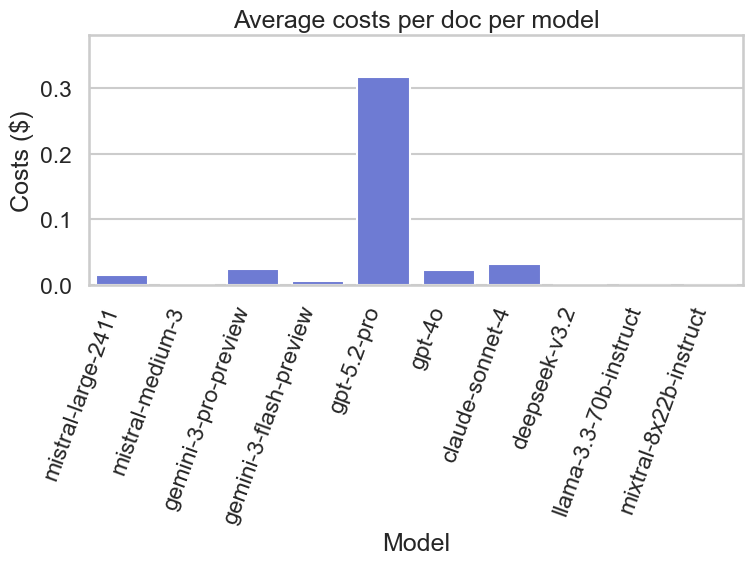

In [45]:
# average cost per model
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="model",
    y="avg_cost_usd",
    data=model_cost_df,
    color="#5D6FE4"
)

plt.xticks(rotation=70, ha="right")
plt.ylim(0, model_cost_df["avg_cost_usd"].max() * 1.2)

plt.xlabel("Model")
plt.ylabel("Costs ($)")
plt.title("Average costs per doc per model")

plt.tight_layout()
plt.savefig("costs_per_model.png")
plt.show()

For benchmark scores:

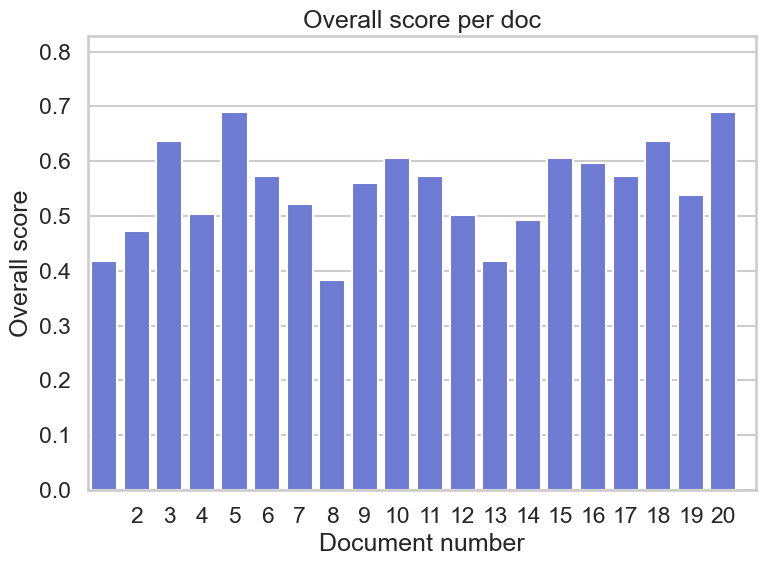

In [ ]:
# overall score per doc
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="doc_number",
    y="document_overall_score",
    data=doc_overall_scores,
    color="#5D6FE4"
)

plt.xticks(doc_overall_scores["doc_number"])
plt.ylim(0, doc_overall_scores["document_overall_score"].max() * 1.2)
plt.xlabel("Document number")
plt.ylabel("Overall score")
plt.title("Overall score per doc")

plt.tight_layout()
plt.savefig("overall_per_document.png")
plt.show()


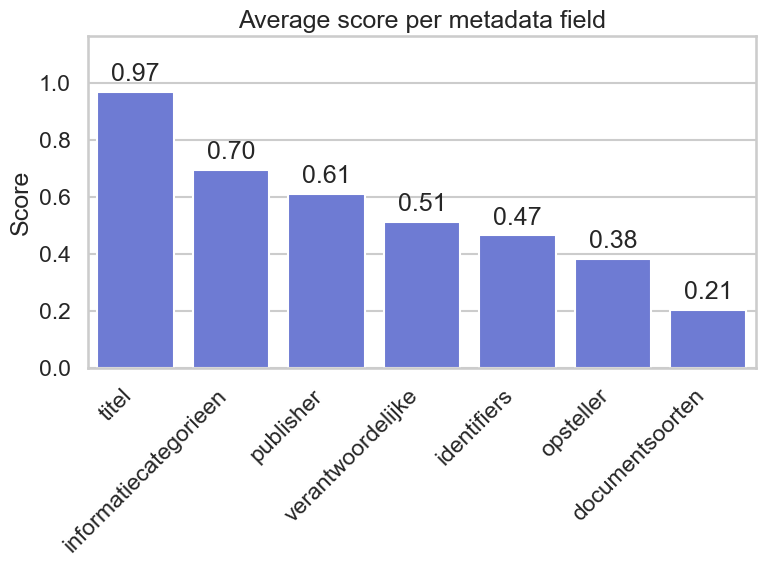

In [ ]:
# average score per metadata field
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="field",
    y="field_average_score",
    data=field_average_scores,
    color="#5D6FE4"
)

plt.xticks(rotation=45, ha="right")
plt.ylim(0, field_average_scores["field_average_score"].max() * 1.2)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Average score per metadata field")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=4)

plt.tight_layout()
plt.savefig("average_per_field.png")
plt.show()



## Generate PDF report

In [44]:
# =============================
# Aggregations
# =============================

doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1

field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

total_overall_score = doc_overall_scores["document_overall_score"].mean()

avg_total_tokens = costs_df["total_tokens"].mean()
avg_cost = costs_df["cost_usd"].mean()

# =============================
# Example Comparisons (with wrapping)
# =============================

styles = getSampleStyleSheet()

small_style = ParagraphStyle(
    name="Small",
    parent=styles["Normal"],
    fontSize=8,
    leading=10
)

sample_rows = benchmark_df.head(21)

example_table_data = [
    ["Doc", "Field", "Official", "LLM", "Score"]
]

for _, row in sample_rows.iterrows():
    example_table_data.append([
        Paragraph(row["doc_id"][:8], small_style),
        Paragraph(str(row["field"]), small_style),
        Paragraph(str(row["official_value"]), small_style),
        Paragraph(str(row["llm_value"]), small_style),
        Paragraph(str(round(row["score"], 3)), small_style),
    ])

# =============================
# Generate PDF
# =============================

pdf_path = "LLM_Metadata_Benchmark_Report_Final.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
elements = []

title_style = styles["Heading1"]
section_style = styles["Heading2"]
normal = styles["Normal"]

# Title
elements.append(Paragraph("LLM Metadata Benchmark Report", title_style))
elements.append(Spacer(1, 20))

# Introduction
elements.append(Paragraph("Introduction", section_style))
elements.append(Spacer(1, 10))

intro_text = """
To assess whether metadata generation by a Large Language Model (LLM) 
is sufficiently reliable for documents published via the GPP-WOO 
publication platform, a benchmark test was conducted.

For this benchmark, 20 documents were selected via OpenOverheid 
(<a href="https://open.overheid.nl/home" color="blue">https://open.overheid.nl/home</a>). For each document in this test set, 
the official metadata was compared with the metadata generated by the LLM. 
The model used for this report is Mistral Large 2411.

The comparison focuses exclusively on the metadata fields that are 
actually used within the publication process of the GPP-WOO platform.

The applied comparison methodology differs per field type. Depending 
on the nature of the field, fuzzy string similarity, set overlap, 
or semantic overlap is used. Based on this, a score is calculated per 
field and per document, after which aggregated results provide insight 
into the overall performance of the LLM.
"""

elements.append(Paragraph(intro_text, normal))
elements.append(Spacer(1, 20))

# Methodology
elements.append(Paragraph("Comparison Methodology", section_style))
elements.append(Spacer(1, 10))

methods = [
    "Title → Fuzzy string similarity",
    "Identifiers → Set overlap (Jaccard)",
    "Information categories → Fuzzy semantic overlap",
    "Document types → Fuzzy overlap",
    "Publisher / Responsible authority / Author → Fuzzy string similarity"
]

elements.append(ListFlowable(
    [ListItem(Paragraph(m, normal)) for m in methods],
    bulletType="bullet"
))
elements.append(Spacer(1, 20))

# Numerical Results
elements.append(Paragraph("Numerical Results", section_style))
elements.append(Spacer(1, 10))

elements.append(Paragraph(
    f"Overall average score: {round(total_overall_score, 3)}",
    normal
))
elements.append(Spacer(1, 20))

field_table_data = [["Metadata field", "Average score"]]
for _, row in field_average_scores.iterrows():
    field_table_data.append([row["field"], round(row["field_average_score"], 3)])

field_table = Table(field_table_data)
field_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
]))

elements.append(field_table)
elements.append(PageBreak())

# Token & Cost Summary
elements.append(Paragraph(
    f"Average number of LLM tokens per document: {round(avg_total_tokens)}",
    normal
))
elements.append(Paragraph(
    f"Average cost per document for Mistral Large 2411: ${round(avg_cost, 3)}",
    normal
))
elements.append(Spacer(1, 20))

cost_table_data = [["Model", "Average cost per document (USD)"]]

for _, row in model_cost_df.iterrows():
    cost_table_data.append([
        row["model"],
        f"${row['avg_cost_usd']:.4f}"
    ])

cost_table = Table(cost_table_data)
cost_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
]))

elements.append(cost_table)
elements.append(Spacer(1, 20))

# Visualizations
elements.append(Paragraph("Visualizations", section_style))
elements.append(Spacer(1, 20))
elements.append(Image("overall_per_document.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("average_per_field.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("costs_per_document.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("costs_per_model.png", width=5*inch, height=4*inch))

elements.append(PageBreak())

# Example Comparisons
elements.append(Paragraph("4. Example Comparisons", section_style))
elements.append(Spacer(1, 10))

example_table = Table(
    example_table_data,
    colWidths=[0.7*inch, 1.0*inch, 2.4*inch, 2.4*inch, 0.6*inch]
)

example_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.3, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "TOP"),
    ("LEFTPADDING", (0, 0), (-1, -1), 4),
    ("RIGHTPADDING", (0, 0), (-1, -1), 4)
]))

elements.append(example_table)

doc.build(elements)

print("PDF generated:", pdf_path)

PDF generated: LLM_Metadata_Benchmark_Report_Final.pdf
